### Using scikit-learn Pipelines

Work with the 'spooky author identification dataset` that can be found on Kaggle. https://www.kaggle.com/c/spooky-author-identification

Objective of the competition:

The competition dataset contains text from works of fiction written by spooky authors of the public domain:

- Edgar Allan Poe (EAP)
- HP Lovecraft (HPL)
- Mary Wollstonecraft Shelley (MWS)

The objective is to accurately identify the author of the sentences in the test set.

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes

import sys
sys.path.insert(0, 'helper_functions/')
from ml_visuals import pprint_confusion_matrix

#paths
PATH = 'data/spooky_dataset/'

/home/diederik/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv(PATH + 'train.csv')
print("Number of rows in train dataset : ",df.shape[0])

Number of rows in train dataset :  19579


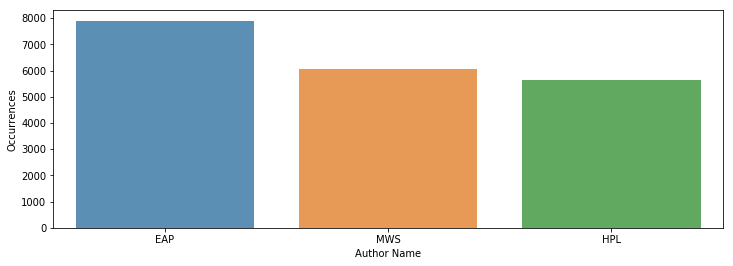

In [3]:
# check class imbalance.. looks good
cnt_srs = df['author'].value_counts()

fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, ax=ax)
_ = ax.set(ylabel ='Occurrences', xlabel = 'Author Name')

In [4]:
grouped = df.groupby('author')
for name, group in grouped:
    print ('author name: {}'.format(name))
    cnt = 0
    for ind, row in group.iterrows():
        print (row['text'])
        cnt += 1
        if cnt == 5:
            break
    print ('\n')

author name: EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you could 

### preprocessing and feature engineering

We will start with creating meta featues and see how good are they at predicting the spooky authors. The feature list is as follows:

- length of sentence
- Number number of words
- Number number of words w/o stopwords
- Average length of the words
- number of commas

In [5]:
import re
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

def text_processing(df):
    """
    clean the text corpus for ml purposes and generate features
    input
     df --> Pandas dataframe
    output
     Pandas dataframe
    """
    # removing punctuation + lowering 
    df['processed'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
    
    # length of sentence
    df['length'] = df['processed'].apply(lambda x: len(x))
    
    # number of words
    df['words'] = df['processed'].apply(lambda x: len(x.split(' ')))
    
    # number of words w/o stopwords
    df['words_no_stop'] = df['processed']\
    .apply(lambda x: len([t for t in x.split(' ') if t not in stopwords]))
    
    # average length of words
    df['avg_word_length'] = df['processed']\
    .apply(lambda x: np.mean([len(t) for t in x.split(' ') if t not in stopwords]) \
     if len([len(t) for t in x.split(' ') if t not in stopwords]) > 0 else 0)
    
    # number of commas
    df['commas'] = df['text'].apply(lambda x: x.count(','))
    
    return df

In [6]:
df = text_processing(df)

Sklearn pipelines facilitate commonly occuring steps. First, split the data into training and testing.

In [7]:
features = [c for c in df.columns.values if c not in ['id', 'text', 'author']]
numeric_features= [c for c in df.columns.values if c  not in ['id','text','author','processed']]
target = 'author'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=.33, random_state=10)
print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))
print('X_test: {}'.format(X_test.shape))
print('y_test: {}'.format(y_test.shape))

X_train: (13117, 6)
y_train: (13117,)
X_test: (6462, 6)
y_test: (6462,)


In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

Execution is like any other transformer. You can call `text.fit()` to fit to training data, `text.transform()` to apply it to training data, or `text.fit_transform()` to do both.

In [23]:
text = Pipeline([('selector', TextSelector(key='processed')),
                 ('tfidf', TfidfVectorizer(stop_words='english'))])
length = Pipeline([('selector', NumberSelector(key='length')),
                   ('standard', StandardScaler())])
words =  Pipeline([('selector', NumberSelector(key='words')),
                   ('standard', StandardScaler())])
words_no_stop =  Pipeline([
                ('selector', NumberSelector(key='words_no_stop')),
                ('standard', StandardScaler())])
avg_word_length =  Pipeline([
                ('selector', NumberSelector(key='avg_word_length')),
                ('standard', StandardScaler())])
commas =  Pipeline([
                ('selector', NumberSelector(key='commas')),
                ('standard', StandardScaler())])

from sklearn.pipeline import FeatureUnion
feats = FeatureUnion([('text', text), 
                      ('length', length),
                      ('words', words),
                      ('words_no_stop', words_no_stop),
                      ('avg_word_length', avg_word_length),
                      ('commas', commas)])

In [24]:
feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<13117x21422 sparse matrix of type '<class 'numpy.float64'>'
	with 213556 stored elements in Compressed Sparse Row format>

In [25]:
from sklearn.ensemble import RandomForestClassifier
p = Pipeline([('features', feats), 
          ('clf', RandomForestClassifier(random_state=10)),])

In [27]:
p.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text', Pipeline(memory=None,
     steps=[('selector', TextSelector(key='processed')), ('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='co...stimators=10, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False))])

In [28]:
preds = p.predict(X_test)

In [29]:
np.mean(preds == y_test)

0.6346332404828227

Fit the best pipeline while doing gridsearches is an important part of many pipelines but it is also an expensive operation. The `p.get_params().keys()` shows all available options. Let' s pick some

In [30]:
p.get_params()

{'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=10, verbose=0, warm_start=False),
 'clf__bootstrap': True,
 'clf__class_weight': None,
 'clf__criterion': 'gini',
 'clf__max_depth': None,
 'clf__max_features': 'auto',
 'clf__max_leaf_nodes': None,
 'clf__min_impurity_decrease': 0.0,
 'clf__min_impurity_split': None,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'clf__min_weight_fraction_leaf': 0.0,
 'clf__n_estimators': 10,
 'clf__n_jobs': 1,
 'clf__oob_score': False,
 'clf__random_state': 10,
 'clf__verbose': 0,
 'clf__warm_start': False,
 'features': FeatureUnion(n_jobs=1,
        transformer_list=[('text', Pipeline(memory=None,
      ste

In [35]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time

hp = {'features__text__tfidf__max_df': [0.9, 0.95],
      'features__text__tfidf__ngram_range': [(1,1), (1,2)],
      'features__text__tfidf__norm': ['l1', 'l2'],
      'clf__max_depth': [50,70],
      'clf__min_samples_leaf': [1,2]}

grid_search = GridSearchCV(p, hp, cv=5, verbose=1)
print("Performing grid search...")
print("pipeline:", [name for name, _ in p.steps])
print("parameters:")
pprint(hp)
t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(hp.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__max_depth': [50, 70],
 'clf__min_samples_leaf': [1, 2],
 'features__text__tfidf__max_df': [0.9, 0.95],
 'features__text__tfidf__ngram_range': [(1, 1), (1, 2)],
 'features__text__tfidf__norm': ['l1', 'l2']}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  3.6min finished


done in 214.904s

Best score: 0.625
Best parameters set:
	clf__max_depth: 70
	clf__min_samples_leaf: 2
	features__text__tfidf__max_df: 0.9
	features__text__tfidf__ngram_range: (1, 1)
	features__text__tfidf__norm: 'l1'


In [15]:
best_params = clf.best_params_

In [26]:
GridSearchCV(p, cv=5, **best_params)

TypeError: __init__() got an unexpected keyword argument 'clf__max_depth'